## Ocean Biogeochemical Dynamics Lab, Spring 2021
Introduction to Python and Jupyter Notebooks by Nancy Williams

Importing and cleaning SOCCOM float data for a single float

In [ ]:
# This is how you make a comment!
# Always annotate your code so you know what you did and why
# I promise you won't remember the details when it comes time to write up the results

# Ideally, you are also using some kind of version control like github
# version control allows you to track changes in your code, revert back if you need to,
# or even branch a piece of code off into two independent versions.
# Also great for collaborative projects

# Import toolboxes
Always start by importing the tools you will need.

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots too
import cartopy.crs as ccrs
import cartopy.feature
%matplotlib inline 
# this forces matplotlib to print figures out here when you make plots

# Press Shift + Enter to "run" this cell and move on to the next one
# Press Option + Enter to add run and an empty cell below this one 

Start a new "cell" when you transition to a new step in your code. This allows you to run your code in chunks and better troubleshoot where issues might be.
# Download the SOCCOM float data snapshot
This code imports a SOCCOM biogeochemical Argo Float "snapshot" dataset from December 2020 for one float. A snapshot means that the data have been archived with a "doi" or digital object identifier. It is frozen in time and is citable, whic is important for reproducibiity. When using this dataset for science, it will also be important to document the steps you take when cleaning, reformatting, renaming, changing units, and any calculations you do. 

The entire .zip file with all floats can be downloaded here: 
https://library.ucsd.edu/dc/object/bb94601812 as the "LIAR High resolution ODV format"

The SOCCOM floats measure pH and other carbonate system parameters are estimated by combining float-measured pH with an estimate for alkalinity based on empirical relationships and shipboard bottle samples. There are several options for this alkalinity product (LIAR, MLR, and CANYON). Here we will use LIAR (Locally Interpolated Alkalinity Regression of Carter et al. (2018) http://doi.wiley.com/10.1002/lom3.10232). 

The files are also available in low resolution and high resolution. The core physical sensors (temperature, salinity, and pressure) measure at a higher depth resolution than the BGC sensors. If you choose low-resolution you lose this high resolution physical data. If you choose high resolution you get the full resolution of physical data and the depths which have no BGC data are empty.

There are both raw and QC files available. The QC (quality control) methods are quite mature at this point and so it is best to use the QC'ed data. If you are working on a project that focuses on sensor QC or you wish to do your own QC, then you may need to download the raw dataset.

It is easiest to place the file in the same directory where you will keep this code. Go download, and then go and unzip that file. What's inside?


# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called "flt". Float 9254 is a good example float, but you can pick any float from the snapshot.

In [100]:
# Pick a float"
floatnum='9254' #you can change this number to look at a different float

floatpath='SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/'
floatsuffix='SOOCN_HRQC.TXT'
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False)
# There are a bunch of other input options for this function, and you can see them by
# pressing "tab" inside the function

b'Skipping line 24: expected 1 fields, saw 3\nSkipping line 27: expected 1 fields, saw 3\nSkipping line 29: expected 1 fields, saw 2\nSkipping line 30: expected 1 fields, saw 6\nSkipping line 31: expected 1 fields, saw 2\nSkipping line 32: expected 1 fields, saw 2\nSkipping line 36: expected 1 fields, saw 3\nSkipping line 38: expected 1 fields, saw 3\nSkipping line 40: expected 1 fields, saw 3\nSkipping line 41: expected 1 fields, saw 2\nSkipping line 42: expected 1 fields, saw 3\nSkipping line 44: expected 1 fields, saw 2\nSkipping line 46: expected 1 fields, saw 2\nSkipping line 48: expected 1 fields, saw 2\nSkipping line 49: expected 1 fields, saw 5\nSkipping line 53: expected 1 fields, saw 3\nSkipping line 55: expected 1 fields, saw 4\nSkipping line 59: expected 1 fields, saw 3\nSkipping line 64: expected 1 fields, saw 4\nSkipping line 82: expected 1 fields, saw 4\n'


In [101]:
# Python doesn't typically spit out the results unless you ask for them.
# This is how you look at just the "head" the flt dataframe
flt.head()

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 19:30
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904395
4,//Univ. of Washington ID: 9254


In [103]:
# This is how you look at the whole flt dataframe
flt

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 19:30
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904395
4,//Univ. of Washington ID: 9254
...,...
93715,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93716,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93717,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93718,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...


## Comments
Clearly something is wrong. We didn't get any meaningful data! Why? Because those are comment lines in the top of the data file.  Let's try telling read_cvs what a comment looks like. We see from the file that the comment lines start with '//'.

In [104]:
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False, comment='/')
# There are a bunch of other input options for this function, and you can see them by
# typing a comma and then pressing "tab" from inside the function parentheses
# Run this new read_csv function and look at the header of the new flt dataframe
# By running this code you overwrite your last flt dataframe
flt.head()

,Cruise\tStation\tType\tmon
0,5904395\t1\tC\t04
1,5904395\t1\tC\t04
2,5904395\t1\tC\t04
3,5904395\t1\tC\t04
4,5904395\t1\tC\t04


## Delimiters
We are getting warmer, we now see a more meaningful header and some data, but what are those "\t"s? Those are tab delimiters/separators. CSV means comma separated values and TSV means tab separated values. The files typically look identical and the tab delimiters are invisible when viewed from excel or a text editor (but you should never use excel to edit text files!). So now we need to tell read_csv what the delimiter is:

In [105]:
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False, 
                comment='/', delimiter='\t')
# If your line of code is getting long and you're inside a parentheses, simply press 
# enter in the code to continue your code onto a new line
# Look at the header
flt.head()

,Cruise,Station,Type,mon
0,5904395,1,C,4
1,5904395,1,C,4
2,5904395,1,C,4
3,5904395,1,C,4
4,5904395,1,C,4


In [106]:
# That looks better, now let's look at the info for the file to see more:
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cruise   93657 non-null  int64 
 1   Station  93657 non-null  int64 
 2   Type     93657 non-null  object
 3   mon      93657 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.9+ MB


We are getting many rows of data, but only four columns. Why? 

Because the "comment" character used in these float data files is two forward slashes "//". Unfortunately, Pandas read_csv can only handle one character in the comment field. Because we entered '/' as the comment character, we also lose everything after any '/'. In this case, we lose everything after "mon" in the header row and in all data rows. When creating a data file like this .txt file, you should never use your delimiter/separator character anywhere else in your data file. To work around this, we will first open the file and replace all instances of '//' with '#'. (I checked to make sure "#" isn't used in the actual data anywhere)

In [108]:
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

## NaN values
NAN (Not A Number) values are used to fill in where there is either no data or sometimes bad data which has been removed. SOCCOM used an absurdly small number which is not zero, but is so small that you would never get the value from a sensor. You could also use an absurdly large number.

In [109]:
flt=pd.read_csv('fltrem.txt',delimiter='\t',comment='#',na_values=-1E10)
# Now I've also added a term to tell read_csv what the "not a number" value is in the file

In [110]:
#take a look at the info for the flt dataframe you have made
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cruise               93657 non-null  int64  
 1   Station              93657 non-null  int64  
 2   Type                 93657 non-null  object 
 3   mon/day/yr           93657 non-null  object 
 4   hh:mm                93657 non-null  object 
 5   Lon [°E]             93657 non-null  float64
 6   Lat [°N]             93657 non-null  float64
 7   QF                   93657 non-null  int64  
 8   Pressure[dbar]       93485 non-null  float64
 9   QF.1                 93485 non-null  float64
 10  Temperature[°C]      93485 non-null  float64
 11  QF.2                 93485 non-null  float64
 12  Salinity[pss]        93485 non-null  float64
 13  QF.3                 93485 non-null  float64
 14  Sigma_theta[kg/m^3]  93485 non-null  float64
 15  QF.4                 93485 non-null 

In [111]:
# look at the head of the data frame
flt.head()

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,...,pHinsitu[Total],QF.14,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18
0,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1598.67,0.0,...,7.8275,0.0,7.5726,0.0,2339.0,0.0,2252.0,0.0,564.3,0.0
1,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1498.62,0.0,...,7.8265,0.0,7.5703,0.0,2328.0,0.0,2242.0,0.0,570.1,0.0
2,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1399.08,0.0,...,7.8334,0.0,7.5757,0.0,2313.0,0.0,2226.0,0.0,564.0,0.0
3,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1298.90,0.0,...,24.6429,8.0,NaN,1.0,2303.0,0.0,NaN,1.0,NaN,1.0
4,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1199.63,0.0,...,7.8602,0.0,7.6039,0.0,2298.0,0.0,2201.0,0.0,539.0,0.0


## Dates
Notice that the date format is in a text string, and we will want it in a number or "datetime" format. We can use a pandas function to_datetime to do this conversion and the new variable 'date' is appended to the end of the pandas dataframe.

In [113]:
flt['date']=pd.to_datetime(flt['mon/day/yr']+' '+ flt['hh:mm'])
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cruise               93657 non-null  int64         
 1   Station              93657 non-null  int64         
 2   Type                 93657 non-null  object        
 3   mon/day/yr           93657 non-null  object        
 4   hh:mm                93657 non-null  object        
 5   Lon [°E]             93657 non-null  float64       
 6   Lat [°N]             93657 non-null  float64       
 7   QF                   93657 non-null  int64         
 8   Pressure[dbar]       93485 non-null  float64       
 9   QF.1                 93485 non-null  float64       
 10  Temperature[°C]      93485 non-null  float64       
 11  QF.2                 93485 non-null  float64       
 12  Salinity[pss]        93485 non-null  float64       
 13  QF.3                 93485 non-

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

### Where is your float in relation to the fronts of the ACC?

In [138]:
stf=pd.read_csv('fronts/stf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saf=pd.read_csv('fronts/saf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
pf=pd.read_csv('fronts/pf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saccf=pd.read_csv('fronts/saccf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
sbdy=pd.read_csv('fronts/sbdy.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
pf

,lon,lat
0,NaN,NaN
1,-179.97,-61.71
2,-179.21,-61.54
3,-178.66,-61.42
4,-178.18,-61.31
...,...,...
965,177.47,-62.40
966,177.90,-62.31
967,178.45,-62.16
968,179.16,-61.95


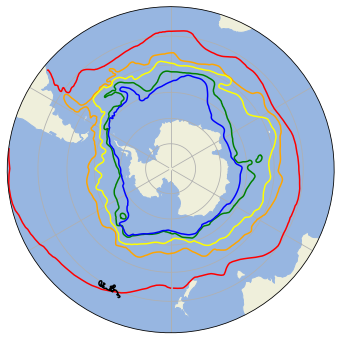

In [139]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
plt.plot(stf['lon'],stf['lat'],color='Red',transform=ccrs.PlateCarree())
plt.plot(saf['lon'],saf['lat'],color='Orange',transform=ccrs.PlateCarree())
plt.plot(pf['lon'],pf['lat'],color='Yellow',transform=ccrs.PlateCarree())
plt.plot(saccf['lon'],saccf['lat'],color='Green',transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'],sbdy['lat'],color='Blue',transform=ccrs.PlateCarree())

plt.plot(flt['Lon [°E]'],flt['Lat [°N]'],color='Black',transform=ccrs.PlateCarree())
plt.savefig('SPstereo.pdf')
plt.savefig('SPstereo.png') # Changing the suffix will change the format
plt.show()

# Plotting profiles

Now, let's make a quick plot of temperature versus pressure. This method is quick and dirty but doesn't give us much control over the figure

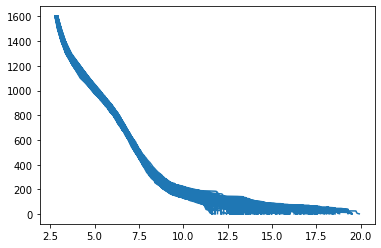

In [140]:
plt.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])

Text(0, 0.5, 'Pressure [dbar]')

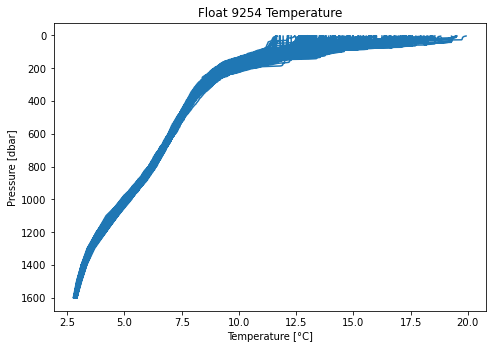

In [141]:
# Something funny? 
# We want to invert the axis and add some labels

# Now we will use the object-oriented programming to have more control over the plot
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0, 0, 1, 1])
axes1.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
axes1.set_title('Float '+floatnum+' Temperature')
axes1.invert_yaxis()
axes1.set_xlabel('Temperature [°C]')
axes1.set_ylabel('Pressure [dbar]')
# if you wanted to add a subplot you would add it like this
#axes2= fig.add_axes([.7, .7, .2, .2])

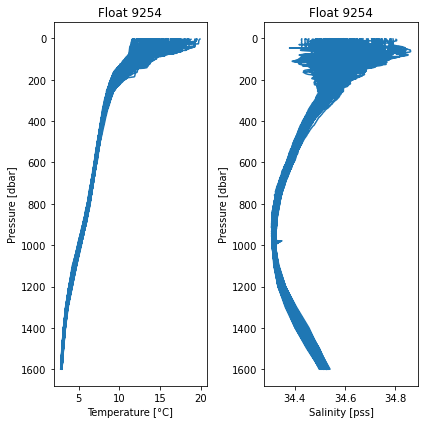

In [142]:
# Can also use subplots function
fig,axes = plt.subplots(nrows = 1, ncols = 2,figsize=(6,6))
# if you have many subplots and some overlap, use tight_layout, or you can leave it 
# at the end of all of your plot statements
# plt.tight_layout()

axes[0].plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
#axes[0].set_title('Temperature')
axes[0].invert_yaxis()
axes[0].set_ylabel('Pressure [dbar]')
axes[0].set_xlabel('Temperature [°C]')

axes[1].plot(flt['Salinity[pss]'],flt['Pressure[dbar]'])
#axes[1].set_title('Salinity')
axes[1].invert_yaxis()
axes[1].set_ylabel('Pressure [dbar]')
axes[1].set_xlabel('Salinity [pss]')
axes[0].set_title('Float '+floatnum)
axes[1].set_title('Float '+floatnum)
plt.tight_layout()
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig('F'+floatnum+'TS.png', dpi = 200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cruise               93657 non-null  int64         
 1   Station              93657 non-null  int64         
 2   Type                 93657 non-null  object        
 3   mon/day/yr           93657 non-null  object        
 4   hh:mm                93657 non-null  object        
 5   Lon [°E]             93657 non-null  float64       
 6   Lat [°N]             93657 non-null  float64       
 7   QF                   93657 non-null  int64         
 8   Pressure[dbar]       93485 non-null  float64       
 9   QF.1                 93485 non-null  float64       
 10  Temperature[°C]      93485 non-null  float64       
 11  QF.2                 93485 non-null  float64       
 12  Salinity[pss]        93485 non-null  float64       
 13  QF.3                 93485 non-

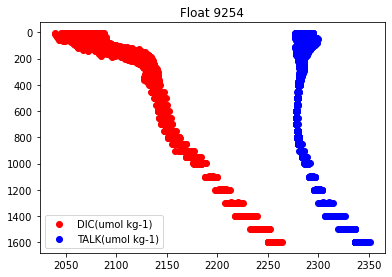

In [146]:
# Now let's plot multiple things on one axis
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt['DIC_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'DIC(umol kg-1)', color = 'red')
ax.scatter(flt['TALK_LIAR[µmol/kg]'],flt['Pressure[dbar]'],label = 'TALK(umol kg-1)', color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float '+floatnum)# Figure out how to have this be dynamic and change with the float number
ax.invert_yaxis()
fig.savefig('F'+floatnum+'DICTALK.png', dpi = 200)
flt.info()

## Quality Flags
Clearly there are some bad data. Notice the QF or Quality Flag columns in the flt dataframe. These tell us which data are good, questionable, and bad. We only want to use good data. How can we tell which data are good?

Go back to the original text file and read the comments at the top of the file. Good data are flagged with zeros, and we should remove bad and questionable data which are flagged 4 and 3, respectively, and replace with NaN. There are better ways to automate this, but for now we will do it manually.

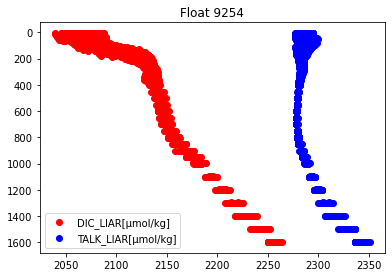

In [170]:
# This is where we left off in class on Jan 22
# Plotting DIC and total alkalinity
var='DIC_LIAR[µmol/kg]'
var2='TALK_LIAR[µmol/kg]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

# Now replot that same figure
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt[var],flt['Pressure[dbar]'],label = var, color = 'red')
ax.scatter(flt[var2],flt['Pressure[dbar]'],label = var2, color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float '+floatnum)
ax.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+var2[0:3]+'.png', dpi = 200)

Careful, if you use "plot" we get a HUGE gap in the mid-water column because the BGC data are not high resolution. We need to use 'scatter' for the BGC data.

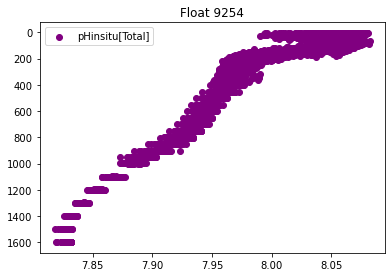

In [171]:
var='pHinsitu[Total]'

fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='purple')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'.png', dpi = 200)

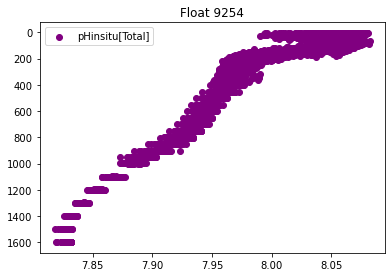

In [172]:
var='pHinsitu[Total]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='purple')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'QC.png', dpi = 200)

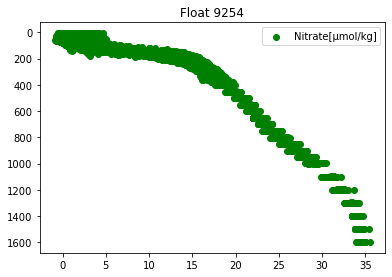

In [173]:
# is nitrate there?
var='Nitrate[µmol/kg]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='green')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'QC.png', dpi = 200)

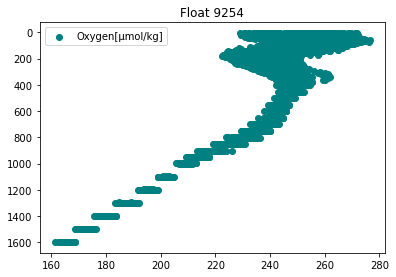

In [174]:
# is oxygen there?
var='Oxygen[µmol/kg]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='teal')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'QC.png', dpi = 200)

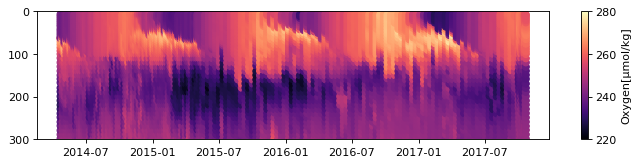

In [176]:
# Next look at oxygen over time
var='Oxygen[µmol/kg]'
fig = plt.figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'magma',)
ax.invert_yaxis()
ax.set_ylim([300,0])
cb=plt.colorbar(sc)
cb.set_label(var)
sc.set_clim(vmin = 220, vmax = 280) # later make these adaptive to values in the depth range

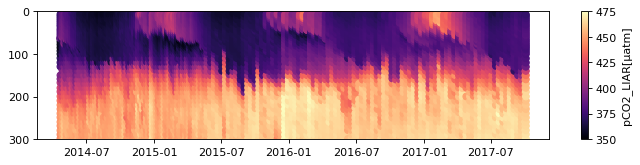

In [178]:
# Next look at pCO2 over time
var='pCO2_LIAR[µatm]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'magma')
ax.invert_yaxis()
ax.set_ylim([300,0])
cb=plt.colorbar(sc)
cb.set_label(var)
sc.set_clim(vmin = 350, vmax = 475) 


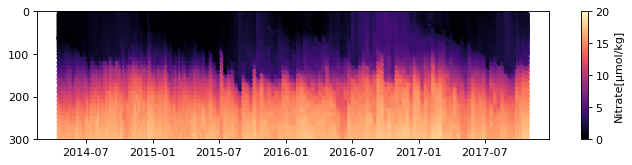

In [179]:
# Next look at Nitrate over time
var='Nitrate[µmol/kg]'
fig = plt.figure(num=None, figsize=(10, 2), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'magma')
ax.invert_yaxis()
ax.set_ylim([300,0])
cb=plt.colorbar(sc)
cb.set_label(var)
sc.set_clim(vmin = 0, vmax = 20) 


/Users/williams/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Temperature[°C]', ylabel='Density'>

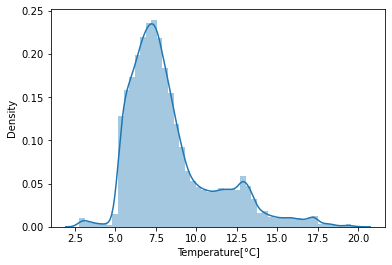

In [180]:
var='Temperature[°C]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
var='Salinity[pss]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

sns.distplot(flt['Temperature[°C]'],kde='false')

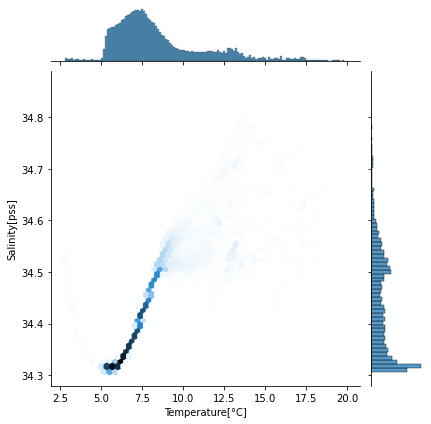

In [181]:
sns.jointplot(x='Temperature[°C]',y='Salinity[pss]',data=flt,kind='hex')

In [185]:
fltsmall=flt[['Nitrate[µmol/kg]','Oxygen[µmol/kg]','pCO2_LIAR[µatm]','Temperature[°C]','Depth[m]']].copy()

In [186]:
fltsmall

,Nitrate[µmol/kg],Oxygen[µmol/kg],pCO2_LIAR[µatm],Temperature[°C],Depth[m]
0,34.93,168.00,564.3,2.8813,1580.407
1,34.69,172.99,570.1,3.0423,1481.850
2,34.22,180.58,564.0,3.2415,1383.750
3,33.32,189.55,NaN,3.6071,1284.973
4,32.10,196.60,539.0,4.0518,1187.047
...,...,...,...,...,...
93652,NaN,NaN,NaN,14.1970,7.940
93653,1.60,257.49,NaN,14.1973,7.593
93654,NaN,NaN,NaN,14.1970,5.955
93655,NaN,NaN,NaN,14.1970,4.367


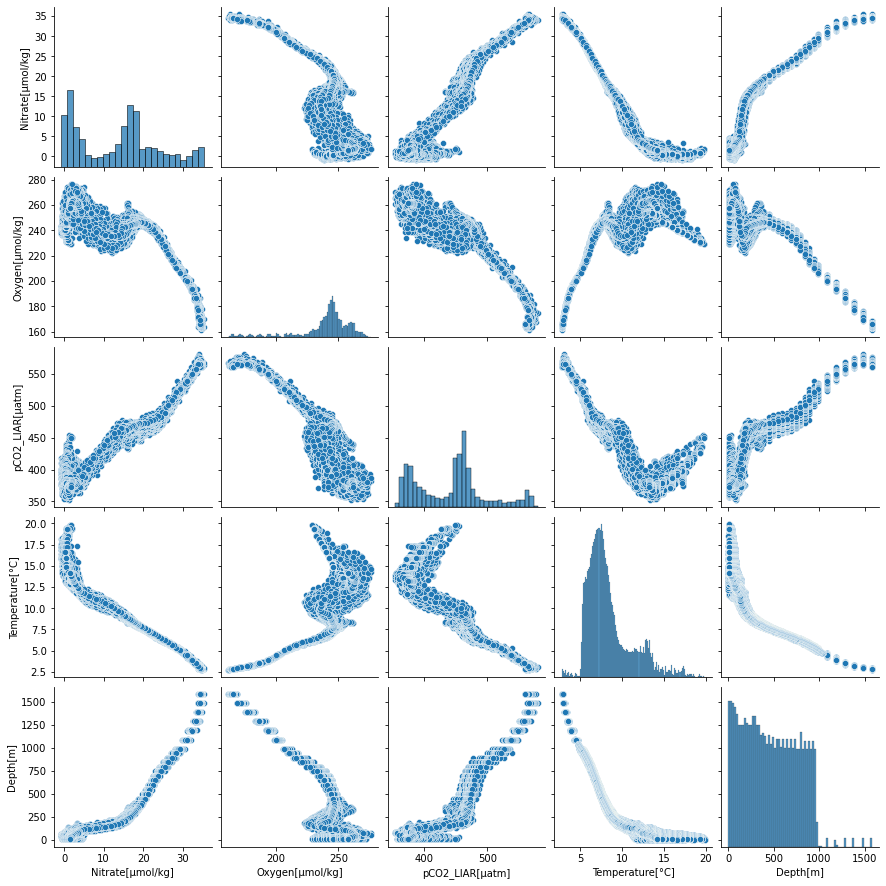

In [187]:
sns.pairplot(fltsmall)
# This will take some time. Notice the "*" that appears to the upper left while the cell runs
# If something is taking longer to run than you think it should, that's called "hanging" and
# It may be due to an error. You can quit that cell by going up to "Kernel" in the menu bar and 
# clicking "interrupt"

In [188]:
# Use this code to subsample the larger dataframe to be used with seaborn grid plots
# a=flt.pivot_table(index='Pressure[dbar]',columns='Station',values='Temperature[°C]')
# a

In [ ]:
# Regression plots
# What is the relationsihp between TALK and S? Do you think that Alkalinity can be estimated from just salinity?
sns.lmplot(x='Salinity[pss]',y='TALK_LIAR[µmol/kg]',data=flt)

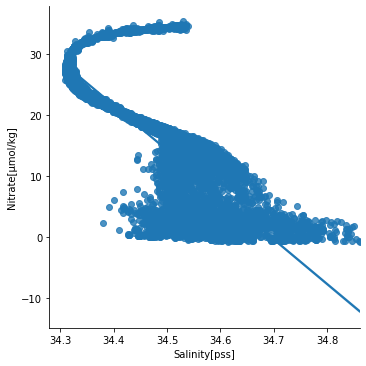

In [191]:
sns.lmplot(x='Salinity[pss]',y='Nitrate[µmol/kg]',data=flt) #Seaborn linear model plot

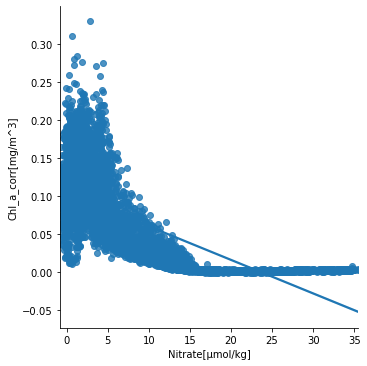

In [ ]:
# What are these two different blobs? Plot a third variable as a color
flt.plot.scatter(x='Salinity[pss]',y='DIC_LIAR[µmol/kg]',c='Pressure[dbar]',cmap='Purples')

In [ ]:
flt_by_station=flt.groupby('Station').mean() #This doesn't make much oceanographic sense,
# I just wanted to share the groupby tool

In [ ]:
flt_by_station

In [ ]:
# NEXT: Try to use xarray to explore float data
# start with Ryan Abernathy's xarray lesson: 
# https://github.com/rabernat/research_computing/blob/master/content/lectures/python/xarray.ipynb
# Play with cookie-cutter project reproducibility tools from Julius Busecke
# Play with sea-py, mayavi
# http://www.pyngl.ucar.edu/
# https://docs.enthought.com/mayavi/mayavi/installation.html
# https://www.itsonlyamodel.us/argovis-python-api-2.html#section_two

# Machine Learning
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JC014629

# importing CMIP6 data https://towardsdatascience.com/a-quick-introduction-to-cmip6-e017127a49d3